In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import TimeSeriesSplit
from tensorflow import keras
from tensorflow.keras import layers
from utils import *
from datetime import datetime

In [2]:
raw_df = pd.read_csv('data/FCC_reported_calls.csv')

In [3]:
# Drop unused columns
fcc_df = raw_df.drop(columns=['Form','Advertiser Business Number'])

# Create a single date+time column
fcc_df['DateTime'] = fcc_df[['Date of Issue','Time of Issue']].apply(lambda row: parse_date(row.values[0],row.values[1]), axis=1)
# fcc_df.drop(columns=['Date of Issue','Time of Issue'],inplace=True)

# Split up DateTime column
month, day, year, hour, minute = zip(*[(None, None, None, None, None) if dt is None else (dt.month, dt.day, dt.year, dt.hour, dt.minute) for dt in fcc_df['DateTime']])
fcc_df = fcc_df.assign(Month = month, Day = day, Year = year, Hour = hour, Minute = minute)

# Simply string entries for Method and Issue
fcc_df['Method'] = fcc_df['Method'].apply(func=remove_parenthesis)
fcc_df['Issue'] = fcc_df['Issue'].apply(func=remove_parenthesis)

# Remove rows with zip code 00000
fcc_df.drop(fcc_df[fcc_df['Zip'] == '00000'].index, inplace = True) 
fcc_df.drop(fcc_df[(fcc_df['Year'] > 2020) | ((fcc_df['Year'] == 2020) & (fcc_df['Month'] > 11))].index, inplace = True) 
fcc_df.drop(fcc_df[(fcc_df['Year'] < 2014) | ((fcc_df['Year'] == 2014) & (fcc_df['Month'] < 11))].index, inplace = True) # Data collection began October 30th

In [4]:
fcc_df.head()

,Ticket ID,Date of Issue,Time of Issue,Method,Issue,Caller ID Number,Type of Call or Messge,State,Zip,Location (Center point of the Zip Code),DateTime,Month,Day,Year,Hour,Minute
0,100358,01/26/2015,8:35 am,Wireless,Telemarketing,617-681-5500,Prerecorded Voice,WA,98115,"WA 98115\n(47.685291, -122.297534)",2015-01-26 20:35:00,1,26,2015,20,35
1,157640,03/02/2015,2:16 p.m.,Wired,Telemarketing,NaN,Prerecorded Voice,CO,80138,"CO 80138\n(39.518092, -104.688882)",2015-03-02 14:16:00,3,2,2015,14,16
2,104244,01/28/2015,11:00 AM,Wireless,Robocalls,415-964-2785,Prerecorded Voice,FL,33139,"FL 33139\n(25.783695, -80.141739)",2015-01-28 23:00:00,1,28,2015,23,0
3,153519,02/27/2015,11:31 AM,Wired,Robocalls,404-381-1115,Prerecorded Voice,VA,22182,"VA 22182\n(38.932908, -77.267432)",2015-02-27 23:31:00,2,27,2015,23,31
4,145971,02/23/2015,3:24 P.M.,Wireless,Telemarketing,203-204-2992,Live Voice,PA,17403,"PA 17403\n(39.935487, -76.710483)",2015-02-23 15:24:00,2,23,2015,15,24


#### h

In [5]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
rnn_df = fcc_df.copy()
rnn_df = rnn_df.dropna()
rnn_df['Day'] = rnn_df['Day'].apply(lambda x: x if int(x)>=10 else ('0'+str(x)))
rnn_df['Month_Name'] = rnn_df['Month'].apply(lambda x: months[x-1])
rnn_df['Month'] = rnn_df['Month'].apply(lambda x: x if int(x)>=10 else ('0'+str(x)))
rnn_df['Date'] =  rnn_df['Year'].astype(str) + rnn_df['Month'].astype(str) + rnn_df['Day'].astype(str)
rnn_df['Year'] = rnn_df['Year'].apply(lambda x: str(x)[-2:])
rnn_df['Date_Styled'] =  rnn_df['Month_Name'] + '-' + rnn_df['Day'].astype(str) + '-' + rnn_df['Year'].astype(str)
rnn_df.sort_values(by=['Date'],inplace=True)
rnn_df = rnn_df.groupby(['Date','State']).count()['Ticket ID']
idx = pd.IndexSlice
one_state_df = rnn_df.loc[idx[:,'NY']]
one_state_df = one_state_df.to_frame()

In [6]:
one_state_df

,Ticket ID
Date,
20141101,3
20141102,2
20141103,8
20141104,4
20141105,1
...,...
20201103,16
20201104,15
20201105,19


In [7]:
def create_dataset(X, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(X.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
RANDOM_SEED = 100

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [9]:
test_percent = .2

In [10]:
train = one_state_df.iloc[:int(len(one_state_df)*(1-test_percent))] 
test = one_state_df.iloc[int(len(one_state_df)*(1-test_percent)):] 

In [11]:
X_train, y_train = create_dataset(train,5)
X_test, y_test = create_dataset(test,5)

### Parameter picking

#### Picking number of units for layers

In [12]:
scores = [[],[]]

tscv = TimeSeriesSplit(max_train_size=None, n_splits=10)

for n in range(0,250,50):
    temp_scores = []
    # Stacking cross val
    for train_index, test_index in tscv.split(X_train):
        X_train_tscv, X_test_tscv = X_train[train_index], X_train[test_index]
        y_train_tscv, y_test_tscv = y_train[train_index], y_train[test_index]

        model = tf.keras.Sequential()
        model.add(tf.keras.layers.SimpleRNN(
          units=n,
          input_shape=(X_train_tscv.shape[1], X_train_tscv.shape[2])
        ))
        model.add(tf.keras.layers.Dense(units=1))
        model.compile(
          loss='mean_squared_error',
          optimizer=tf.keras.optimizers.Adam(0.001)
        )

        model.fit(
            X_train_tscv, y_train_tscv,
            epochs=30,
            batch_size=16,
            validation_split=0.1,
            shuffle=False
        )
        
        temp_scores.append(model.evaluate(X_test_tscv, y_test_tscv))
    scores[0].append(n)   
    scores[1].append(np.average(temp_scores))

Epoch 1/30
9/9 [==============================] - 0s 23ms/step - loss: 227.5373 - val_loss: 490.7333
Epoch 2/30
9/9 [==============================] - 0s 3ms/step - loss: 227.5373 - val_loss: 490.7333
Epoch 3/30
9/9 [==============================] - 0s 3ms/step - loss: 227.5373 - val_loss: 490.7333
Epoch 4/30
9/9 [==============================] - 0s 3ms/step - loss: 227.5373 - val_loss: 490.7333
Epoch 5/30
9/9 [==============================] - 0s 3ms/step - loss: 227.5373 - val_loss: 490.7333
Epoch 6/30
9/9 [==============================] - 0s 3ms/step - loss: 227.5373 - val_loss: 490.7333
Epoch 7/30
9/9 [==============================] - 0s 3ms/step - loss: 227.5373 - val_loss: 490.7333
Epoch 8/30
9/9 [==============================] - 0s 3ms/step - loss: 227.5373 - val_loss: 490.7333
Epoch 9/30
9/9 [==============================] - 0s 3ms/step - loss: 227.5373 - val_loss: 490.7333
Epoch 10/30
9/9 [==============================] - 0s 3ms/step - loss: 227.5373 - val_loss: 490.733

25/25 [==============================] - 0s 2ms/step - loss: 434.2199 - val_loss: 387.1136
Epoch 21/30
25/25 [==============================] - 0s 1ms/step - loss: 434.2199 - val_loss: 387.1136
Epoch 22/30
25/25 [==============================] - 0s 2ms/step - loss: 434.2199 - val_loss: 387.1136
Epoch 23/30
25/25 [==============================] - 0s 1ms/step - loss: 434.2199 - val_loss: 387.1136
Epoch 24/30
25/25 [==============================] - 0s 1ms/step - loss: 434.2199 - val_loss: 387.1136
Epoch 25/30
25/25 [==============================] - 0s 2ms/step - loss: 434.2199 - val_loss: 387.1136
Epoch 26/30
25/25 [==============================] - 0s 2ms/step - loss: 434.2199 - val_loss: 387.1136
Epoch 27/30
25/25 [==============================] - 0s 2ms/step - loss: 434.2199 - val_loss: 387.1136
Epoch 28/30
25/25 [==============================] - 0s 2ms/step - loss: 434.2199 - val_loss: 387.1136
Epoch 29/30
25/25 [==============================] - 0s 2ms/step - loss: 434.2199 - v

49/49 [==============================] - 0s 1ms/step - loss: 441.2394 - val_loss: 1359.7241
Epoch 6/30
49/49 [==============================] - 0s 1ms/step - loss: 441.2394 - val_loss: 1359.7241
Epoch 7/30
49/49 [==============================] - 0s 1ms/step - loss: 441.2394 - val_loss: 1359.7241
Epoch 8/30
49/49 [==============================] - 0s 2ms/step - loss: 441.2394 - val_loss: 1359.7241
Epoch 9/30
49/49 [==============================] - 0s 2ms/step - loss: 441.2394 - val_loss: 1359.7241
Epoch 10/30
49/49 [==============================] - 0s 2ms/step - loss: 441.2394 - val_loss: 1359.7241
Epoch 11/30
49/49 [==============================] - 0s 2ms/step - loss: 441.2394 - val_loss: 1359.7241
Epoch 12/30
49/49 [==============================] - 0s 1ms/step - loss: 441.2394 - val_loss: 1359.7241
Epoch 13/30
49/49 [==============================] - 0s 1ms/step - loss: 441.2394 - val_loss: 1359.7241
Epoch 14/30
49/49 [==============================] - 0s 1ms/step - loss: 441.239

65/65 [==============================] - 0s 1ms/step - loss: 567.4869 - val_loss: 1196.8260
Epoch 24/30
65/65 [==============================] - 0s 1ms/step - loss: 567.4869 - val_loss: 1196.8260
Epoch 25/30
65/65 [==============================] - 0s 1ms/step - loss: 567.4869 - val_loss: 1196.8260
Epoch 26/30
65/65 [==============================] - 0s 1ms/step - loss: 567.4869 - val_loss: 1196.8260
Epoch 27/30
65/65 [==============================] - 0s 1ms/step - loss: 567.4869 - val_loss: 1196.8260
Epoch 28/30
65/65 [==============================] - 0s 1ms/step - loss: 567.4869 - val_loss: 1196.8260
Epoch 29/30
65/65 [==============================] - 0s 1ms/step - loss: 567.4869 - val_loss: 1196.8260
Epoch 30/30
5/5 [==============================] - 0s 804us/step - loss: 493.7972
Epoch 1/30
73/73 [==============================] - 0s 4ms/step - loss: 629.4222 - val_loss: 489.0692
Epoch 2/30
73/73 [==============================] - 0s 1ms/step - loss: 629.4222 - val_loss: 489.069

9/9 [==============================] - 0s 3ms/step - loss: 113.4448 - val_loss: 276.8290
Epoch 9/30
9/9 [==============================] - 0s 3ms/step - loss: 109.2643 - val_loss: 267.0406
Epoch 10/30
9/9 [==============================] - 0s 4ms/step - loss: 105.7056 - val_loss: 258.3455
Epoch 11/30
9/9 [==============================] - 0s 3ms/step - loss: 102.5298 - val_loss: 250.2875
Epoch 12/30
9/9 [==============================] - 0s 3ms/step - loss: 99.6604 - val_loss: 242.7467
Epoch 13/30
9/9 [==============================] - 0s 3ms/step - loss: 96.9312 - val_loss: 235.3431
Epoch 14/30
9/9 [==============================] - 0s 3ms/step - loss: 94.1525 - val_loss: 227.9416
Epoch 15/30
9/9 [==============================] - 0s 3ms/step - loss: 91.4711 - val_loss: 220.6870
Epoch 16/30
9/9 [==============================] - 0s 3ms/step - loss: 89.3213 - val_loss: 214.0907
Epoch 17/30
9/9 [==============================] - 0s 3ms/step - loss: 87.7450 - val_loss: 208.9187
Epoch 18/

Epoch 25/30
25/25 [==============================] - 0s 2ms/step - loss: 93.9082 - val_loss: 91.9630
Epoch 26/30
25/25 [==============================] - 0s 2ms/step - loss: 91.8631 - val_loss: 91.1448
Epoch 27/30
25/25 [==============================] - 0s 2ms/step - loss: 89.9171 - val_loss: 90.1434
Epoch 28/30
25/25 [==============================] - 0s 2ms/step - loss: 88.0181 - val_loss: 88.7264
Epoch 29/30
25/25 [==============================] - 0s 2ms/step - loss: 86.2792 - val_loss: 87.5627
Epoch 30/30
5/5 [==============================] - 0s 798us/step - loss: 101.4586
Epoch 1/30
33/33 [==============================] - 0s 7ms/step - loss: 378.2284 - val_loss: 309.8681
Epoch 2/30
33/33 [==============================] - 0s 2ms/step - loss: 288.9896 - val_loss: 248.2445
Epoch 3/30
33/33 [==============================] - 0s 2ms/step - loss: 241.4989 - val_loss: 201.6772
Epoch 4/30
33/33 [==============================] - 0s 2ms/step - loss: 206.4735 - val_loss: 170.9917
Epoch

49/49 [==============================] - 0s 2ms/step - loss: 99.7062 - val_loss: 504.8586
Epoch 14/30
49/49 [==============================] - 0s 2ms/step - loss: 95.4011 - val_loss: 490.8504
Epoch 15/30
49/49 [==============================] - 0s 2ms/step - loss: 91.7388 - val_loss: 479.8998
Epoch 16/30
49/49 [==============================] - 0s 2ms/step - loss: 88.7960 - val_loss: 469.4651
Epoch 17/30
49/49 [==============================] - 0s 2ms/step - loss: 86.5941 - val_loss: 460.6908
Epoch 18/30
49/49 [==============================] - 0s 2ms/step - loss: 84.8918 - val_loss: 453.1775
Epoch 19/30
49/49 [==============================] - 0s 2ms/step - loss: 83.5216 - val_loss: 446.7184
Epoch 20/30
49/49 [==============================] - 0s 2ms/step - loss: 82.3775 - val_loss: 441.1035
Epoch 21/30
49/49 [==============================] - 0s 1ms/step - loss: 81.3633 - val_loss: 436.1732
Epoch 22/30
49/49 [==============================] - 0s 1ms/step - loss: 80.3904 - val_loss: 4

5/5 [==============================] - 0s 997us/step - loss: 62.6186
Epoch 1/30
73/73 [==============================] - 0s 4ms/step - loss: 462.6035 - val_loss: 261.7603
Epoch 2/30
73/73 [==============================] - 0s 1ms/step - loss: 327.2252 - val_loss: 189.9487
Epoch 3/30
73/73 [==============================] - 0s 1ms/step - loss: 268.0807 - val_loss: 157.9482
Epoch 4/30
73/73 [==============================] - 0s 1ms/step - loss: 235.6841 - val_loss: 140.3506
Epoch 5/30
73/73 [==============================] - 0s 2ms/step - loss: 213.7291 - val_loss: 131.7408
Epoch 6/30
73/73 [==============================] - 0s 1ms/step - loss: 196.9388 - val_loss: 126.3883
Epoch 7/30
73/73 [==============================] - 0s 1ms/step - loss: 187.0204 - val_loss: 122.0014
Epoch 8/30
73/73 [==============================] - 0s 1ms/step - loss: 178.5775 - val_loss: 115.9416
Epoch 9/30
73/73 [==============================] - 0s 1ms/step - loss: 169.1869 - val_loss: 113.2353
Epoch 10/30
7

9/9 [==============================] - 0s 3ms/step - loss: 62.9953 - val_loss: 144.4226
Epoch 20/30
9/9 [==============================] - 0s 3ms/step - loss: 60.9356 - val_loss: 141.8542
Epoch 21/30
9/9 [==============================] - 0s 3ms/step - loss: 58.9317 - val_loss: 139.1417
Epoch 22/30
9/9 [==============================] - 0s 3ms/step - loss: 57.1281 - val_loss: 136.5493
Epoch 23/30
9/9 [==============================] - 0s 3ms/step - loss: 55.5316 - val_loss: 134.0923
Epoch 24/30
9/9 [==============================] - 0s 3ms/step - loss: 54.1511 - val_loss: 131.6442
Epoch 25/30
9/9 [==============================] - 0s 3ms/step - loss: 52.9594 - val_loss: 129.4383
Epoch 26/30
9/9 [==============================] - 0s 3ms/step - loss: 51.8915 - val_loss: 127.4768
Epoch 27/30
9/9 [==============================] - 0s 3ms/step - loss: 50.9294 - val_loss: 125.6794
Epoch 28/30
9/9 [==============================] - 0s 2ms/step - loss: 50.0822 - val_loss: 124.0597
Epoch 29/30


Epoch 8/30
33/33 [==============================] - 0s 2ms/step - loss: 104.2546 - val_loss: 78.7615
Epoch 9/30
33/33 [==============================] - 0s 2ms/step - loss: 98.9345 - val_loss: 75.3662
Epoch 10/30
33/33 [==============================] - 0s 2ms/step - loss: 94.4586 - val_loss: 73.8613
Epoch 11/30
33/33 [==============================] - 0s 2ms/step - loss: 89.4392 - val_loss: 72.1252
Epoch 12/30
33/33 [==============================] - 0s 2ms/step - loss: 85.4251 - val_loss: 71.3600
Epoch 13/30
33/33 [==============================] - 0s 2ms/step - loss: 83.0208 - val_loss: 70.2217
Epoch 14/30
33/33 [==============================] - 0s 2ms/step - loss: 80.2165 - val_loss: 70.1235
Epoch 15/30
33/33 [==============================] - 0s 2ms/step - loss: 78.4822 - val_loss: 69.7441
Epoch 16/30
33/33 [==============================] - 0s 2ms/step - loss: 76.5379 - val_loss: 69.2179
Epoch 17/30
33/33 [==============================] - 0s 2ms/step - loss: 74.7873 - val_loss:

49/49 [==============================] - 0s 2ms/step - loss: 53.4884 - val_loss: 322.5693
Epoch 28/30
49/49 [==============================] - 0s 2ms/step - loss: 52.0194 - val_loss: 318.7716
Epoch 29/30
49/49 [==============================] - 0s 2ms/step - loss: 50.8556 - val_loss: 317.5442
Epoch 30/30
5/5 [==============================] - 0s 2ms/step - loss: 78.7690
Epoch 1/30
57/57 [==============================] - 0s 5ms/step - loss: 347.6958 - val_loss: 269.4473
Epoch 2/30
57/57 [==============================] - 0s 2ms/step - loss: 213.1554 - val_loss: 199.1748
Epoch 3/30
57/57 [==============================] - 0s 2ms/step - loss: 179.7587 - val_loss: 175.1573
Epoch 4/30
57/57 [==============================] - 0s 2ms/step - loss: 158.5293 - val_loss: 154.3980
Epoch 5/30
57/57 [==============================] - 0s 2ms/step - loss: 142.3288 - val_loss: 130.2222
Epoch 6/30
57/57 [==============================] - 0s 2ms/step - loss: 133.0052 - val_loss: 118.7570
Epoch 7/30
57/5

Epoch 11/30
73/73 [==============================] - 0s 2ms/step - loss: 115.4258 - val_loss: 87.6674
Epoch 12/30
73/73 [==============================] - 0s 2ms/step - loss: 111.8180 - val_loss: 82.2968
Epoch 13/30
73/73 [==============================] - 0s 2ms/step - loss: 108.5909 - val_loss: 78.4943
Epoch 14/30
73/73 [==============================] - 0s 2ms/step - loss: 105.1913 - val_loss: 74.0077
Epoch 15/30
73/73 [==============================] - 0s 2ms/step - loss: 101.8112 - val_loss: 70.8235
Epoch 16/30
73/73 [==============================] - 0s 1ms/step - loss: 98.7419 - val_loss: 63.9522
Epoch 17/30
73/73 [==============================] - 0s 2ms/step - loss: 96.3222 - val_loss: 64.5219
Epoch 18/30
73/73 [==============================] - 0s 2ms/step - loss: 94.1234 - val_loss: 65.4936
Epoch 19/30
73/73 [==============================] - 0s 2ms/step - loss: 91.4879 - val_loss: 63.7144
Epoch 20/30
73/73 [==============================] - 0s 2ms/step - loss: 88.0675 - val

5/5 [==============================] - 0s 1ms/step - loss: 109.0270
Epoch 1/30
17/17 [==============================] - 0s 13ms/step - loss: 240.8630 - val_loss: 361.6869
Epoch 2/30
17/17 [==============================] - 0s 3ms/step - loss: 149.6567 - val_loss: 261.9380
Epoch 3/30
17/17 [==============================] - 0s 3ms/step - loss: 122.5381 - val_loss: 221.0952
Epoch 4/30
17/17 [==============================] - 0s 3ms/step - loss: 113.1210 - val_loss: 204.2228
Epoch 5/30
17/17 [==============================] - 0s 3ms/step - loss: 106.7536 - val_loss: 191.7005
Epoch 6/30
17/17 [==============================] - 0s 2ms/step - loss: 102.1307 - val_loss: 181.0914
Epoch 7/30
17/17 [==============================] - 0s 2ms/step - loss: 98.6867 - val_loss: 173.1743
Epoch 8/30
17/17 [==============================] - 0s 2ms/step - loss: 96.0456 - val_loss: 167.0339
Epoch 9/30
17/17 [==============================] - 0s 2ms/step - loss: 93.9000 - val_loss: 162.2236
Epoch 10/30
17/1

Epoch 19/30
33/33 [==============================] - 0s 2ms/step - loss: 56.3180 - val_loss: 51.2617
Epoch 20/30
33/33 [==============================] - 0s 2ms/step - loss: 54.2339 - val_loss: 50.2643
Epoch 21/30
33/33 [==============================] - 0s 2ms/step - loss: 53.0170 - val_loss: 49.4562
Epoch 22/30
33/33 [==============================] - 0s 2ms/step - loss: 52.2605 - val_loss: 49.5051
Epoch 23/30
33/33 [==============================] - 0s 2ms/step - loss: 52.7126 - val_loss: 48.0334
Epoch 24/30
33/33 [==============================] - 0s 2ms/step - loss: 52.0845 - val_loss: 46.0424
Epoch 25/30
33/33 [==============================] - 0s 2ms/step - loss: 50.9634 - val_loss: 47.3870
Epoch 26/30
33/33 [==============================] - 0s 2ms/step - loss: 48.6598 - val_loss: 43.0200
Epoch 27/30
33/33 [==============================] - 0s 2ms/step - loss: 47.9735 - val_loss: 45.2094
Epoch 28/30
33/33 [==============================] - 0s 2ms/step - loss: 47.3196 - val_loss

57/57 [==============================] - 0s 2ms/step - loss: 124.7590 - val_loss: 112.5008
Epoch 6/30
57/57 [==============================] - 0s 2ms/step - loss: 115.9165 - val_loss: 111.3968
Epoch 7/30
57/57 [==============================] - 0s 2ms/step - loss: 107.5694 - val_loss: 105.9617
Epoch 8/30
57/57 [==============================] - 0s 2ms/step - loss: 100.8365 - val_loss: 98.8783
Epoch 9/30
57/57 [==============================] - 0s 2ms/step - loss: 94.4581 - val_loss: 93.9013
Epoch 10/30
57/57 [==============================] - 0s 2ms/step - loss: 88.7805 - val_loss: 90.8689
Epoch 11/30
57/57 [==============================] - 0s 2ms/step - loss: 85.8154 - val_loss: 89.2889
Epoch 12/30
57/57 [==============================] - 0s 2ms/step - loss: 84.4038 - val_loss: 89.8897
Epoch 13/30
57/57 [==============================] - 0s 2ms/step - loss: 81.9298 - val_loss: 88.1670
Epoch 14/30
57/57 [==============================] - 0s 2ms/step - loss: 78.1835 - val_loss: 81.3882

73/73 [==============================] - 0s 2ms/step - loss: 70.8344 - val_loss: 67.1324
Epoch 25/30
73/73 [==============================] - 0s 2ms/step - loss: 69.3045 - val_loss: 67.8352
Epoch 26/30
73/73 [==============================] - 0s 2ms/step - loss: 67.7897 - val_loss: 67.8627
Epoch 27/30
73/73 [==============================] - 0s 2ms/step - loss: 66.5388 - val_loss: 67.2240
Epoch 28/30
73/73 [==============================] - 0s 2ms/step - loss: 65.3885 - val_loss: 66.5139
Epoch 29/30
73/73 [==============================] - 0s 2ms/step - loss: 64.3029 - val_loss: 65.6507
Epoch 30/30
5/5 [==============================] - 0s 997us/step - loss: 98.5405
Epoch 1/30
81/81 [==============================] - 0s 4ms/step - loss: 258.2831 - val_loss: 169.9436
Epoch 2/30
81/81 [==============================] - 0s 2ms/step - loss: 180.8884 - val_loss: 152.3338
Epoch 3/30
81/81 [==============================] - 0s 2ms/step - loss: 155.5376 - val_loss: 124.5277
Epoch 4/30
81/81 [=

17/17 [==============================] - 0s 3ms/step - loss: 70.7957 - val_loss: 117.5763
Epoch 14/30
17/17 [==============================] - 0s 3ms/step - loss: 67.6784 - val_loss: 111.8024
Epoch 15/30
17/17 [==============================] - 0s 2ms/step - loss: 64.7831 - val_loss: 106.2245
Epoch 16/30
17/17 [==============================] - ETA: 0s - loss: 19.39 - 0s 3ms/step - loss: 62.1605 - val_loss: 101.1297
Epoch 17/30
17/17 [==============================] - 0s 3ms/step - loss: 59.7883 - val_loss: 96.7226
Epoch 18/30
17/17 [==============================] - 0s 3ms/step - loss: 57.6027 - val_loss: 92.3059
Epoch 19/30
17/17 [==============================] - 0s 3ms/step - loss: 55.6628 - val_loss: 88.7079
Epoch 20/30
17/17 [==============================] - 0s 3ms/step - loss: 53.7972 - val_loss: 85.4145
Epoch 21/30
17/17 [==============================] - 0s 3ms/step - loss: 52.3484 - val_loss: 82.7843
Epoch 22/30
17/17 [==============================] - 0s 2ms/step - loss: 50

33/33 [==============================] - 0s 2ms/step - loss: 45.2204 - val_loss: 37.5419
Epoch 30/30
5/5 [==============================] - 0s 1ms/step - loss: 51.6103
Epoch 1/30
41/41 [==============================] - 0s 6ms/step - loss: 163.0038 - val_loss: 132.2087
Epoch 2/30
41/41 [==============================] - 0s 2ms/step - loss: 115.7284 - val_loss: 131.8104
Epoch 3/30
41/41 [==============================] - 0s 2ms/step - loss: 108.8894 - val_loss: 118.3538
Epoch 4/30
41/41 [==============================] - 0s 2ms/step - loss: 102.4260 - val_loss: 112.3700
Epoch 5/30
41/41 [==============================] - 0s 2ms/step - loss: 96.1658 - val_loss: 97.7170
Epoch 6/30
41/41 [==============================] - 0s 2ms/step - loss: 89.9061 - val_loss: 87.6629
Epoch 7/30
41/41 [==============================] - 0s 2ms/step - loss: 85.3819 - val_loss: 73.3975
Epoch 8/30
41/41 [==============================] - 0s 2ms/step - loss: 80.3869 - val_loss: 67.3758
Epoch 9/30
41/41 [======

57/57 [==============================] - 0s 2ms/step - loss: 71.0916 - val_loss: 70.7136
Epoch 18/30
57/57 [==============================] - 0s 2ms/step - loss: 69.4852 - val_loss: 69.6643
Epoch 19/30
57/57 [==============================] - 0s 2ms/step - loss: 67.7454 - val_loss: 70.4500
Epoch 20/30
57/57 [==============================] - 0s 2ms/step - loss: 64.7014 - val_loss: 70.7942
Epoch 21/30
57/57 [==============================] - 0s 2ms/step - loss: 63.8141 - val_loss: 75.7484
Epoch 22/30
57/57 [==============================] - 0s 2ms/step - loss: 62.3997 - val_loss: 68.8031
Epoch 23/30
57/57 [==============================] - 0s 2ms/step - loss: 61.9092 - val_loss: 73.0770
Epoch 24/30
57/57 [==============================] - 0s 2ms/step - loss: 60.1237 - val_loss: 72.2262
Epoch 25/30
57/57 [==============================] - 0s 2ms/step - loss: 60.0515 - val_loss: 70.2025
Epoch 26/30
57/57 [==============================] - 0s 2ms/step - loss: 58.5567 - val_loss: 67.9833
Ep

81/81 [==============================] - 0s 2ms/step - loss: 118.8321 - val_loss: 103.1281
Epoch 6/30
81/81 [==============================] - 0s 2ms/step - loss: 107.1169 - val_loss: 91.8459
Epoch 7/30
81/81 [==============================] - 0s 2ms/step - loss: 100.4654 - val_loss: 87.6659
Epoch 8/30
81/81 [==============================] - 0s 2ms/step - loss: 94.9068 - val_loss: 85.6109
Epoch 9/30
81/81 [==============================] - 0s 2ms/step - loss: 90.7633 - val_loss: 84.3470
Epoch 10/30
81/81 [==============================] - 0s 2ms/step - loss: 88.0204 - val_loss: 84.1799
Epoch 11/30
81/81 [==============================] - 0s 2ms/step - loss: 85.1922 - val_loss: 85.4800
Epoch 12/30
81/81 [==============================] - 0s 2ms/step - loss: 81.9014 - val_loss: 84.6227
Epoch 13/30
81/81 [==============================] - 0s 2ms/step - loss: 77.9532 - val_loss: 86.8088
Epoch 14/30
81/81 [==============================] - 0s 2ms/step - loss: 75.7082 - val_loss: 89.6311
Ep

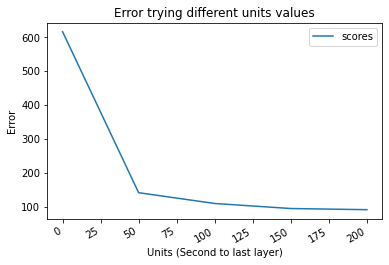

In [13]:
graph_df = pd.DataFrame()
graph_df['scores'] = scores[1]
graph_df.index = scores[0]
graph_df.plot(subplots=True)
plt.title('Error trying different units values')
plt.ylabel('Error')
plt.xlabel('Units (Second to last layer)')
plt.show()

#### Picking number of epochs

In [14]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(
  units=100,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(tf.keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=tf.keras.optimizers.Adam(0.001)
);

In [15]:
history = model.fit(
    X_train, y_train,
    epochs=150,
    validation_split=0.1,
    shuffle=False
);

Epoch 1/150
45/45 [==============================] - 0s 5ms/step - loss: 348.8980 - val_loss: 186.7847
Epoch 2/150
45/45 [==============================] - 0s 2ms/step - loss: 233.6881 - val_loss: 151.5898
Epoch 3/150
45/45 [==============================] - 0s 2ms/step - loss: 201.5197 - val_loss: 142.6526
Epoch 4/150
45/45 [==============================] - 0s 2ms/step - loss: 186.2623 - val_loss: 134.6682
Epoch 5/150
45/45 [==============================] - 0s 2ms/step - loss: 168.0972 - val_loss: 125.7384
Epoch 6/150
45/45 [==============================] - 0s 2ms/step - loss: 152.5906 - val_loss: 122.8602
Epoch 7/150
45/45 [==============================] - 0s 2ms/step - loss: 143.4148 - val_loss: 121.4333
Epoch 8/150
45/45 [==============================] - 0s 2ms/step - loss: 136.2245 - val_loss: 119.3566
Epoch 9/150
45/45 [==============================] - 0s 2ms/step - loss: 129.9579 - val_loss: 119.4410
Epoch 10/150
45/45 [==============================] - 0s 2ms/step - loss:

45/45 [==============================] - 0s 2ms/step - loss: 53.2861 - val_loss: 106.2711
Epoch 81/150
45/45 [==============================] - 0s 2ms/step - loss: 53.0829 - val_loss: 106.3566
Epoch 82/150
45/45 [==============================] - 0s 2ms/step - loss: 52.8788 - val_loss: 106.4246
Epoch 83/150
45/45 [==============================] - 0s 2ms/step - loss: 52.6724 - val_loss: 106.4846
Epoch 84/150
45/45 [==============================] - 0s 2ms/step - loss: 52.4607 - val_loss: 106.5509
Epoch 85/150
45/45 [==============================] - 0s 2ms/step - loss: 52.2436 - val_loss: 106.6403
Epoch 86/150
45/45 [==============================] - 0s 2ms/step - loss: 52.0271 - val_loss: 106.7379
Epoch 87/150
45/45 [==============================] - 0s 2ms/step - loss: 51.8190 - val_loss: 106.8435
Epoch 88/150
45/45 [==============================] - 0s 2ms/step - loss: 51.6164 - val_loss: 106.9617
Epoch 89/150
45/45 [==============================] - 0s 2ms/step - loss: 51.4170 - va

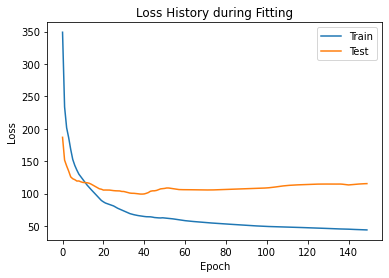

In [16]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title("Loss History during Fitting")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

### Final Model

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(
  units=100,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(tf.keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=tf.keras.optimizers.Adam(0.001)
)

model.fit(
    X_train, y_train,
    epochs=60,
    validation_split=0.1,
    shuffle=False
);

Epoch 1/60
45/45 [==============================] - 0s 5ms/step - loss: 415.2715 - val_loss: 213.8314
Epoch 2/60
45/45 [==============================] - 0s 2ms/step - loss: 254.7346 - val_loss: 156.7630
Epoch 3/60
45/45 [==============================] - ETA: 0s - loss: 200.910 - 0s 2ms/step - loss: 207.4165 - val_loss: 142.5089
Epoch 4/60
45/45 [==============================] - 0s 2ms/step - loss: 188.0663 - val_loss: 133.0880
Epoch 5/60
45/45 [==============================] - 0s 2ms/step - loss: 168.8206 - val_loss: 125.0426
Epoch 6/60
45/45 [==============================] - 0s 2ms/step - loss: 152.0404 - val_loss: 121.4387
Epoch 7/60
45/45 [==============================] - 0s 2ms/step - loss: 142.6346 - val_loss: 119.5807
Epoch 8/60
45/45 [==============================] - 0s 2ms/step - loss: 135.3414 - val_loss: 118.6202
Epoch 9/60
45/45 [==============================] - 0s 2ms/step - loss: 128.9592 - val_loss: 116.5686
Epoch 10/60
45/45 [==============================] - 0s 

In [18]:
y_pred = model.predict(X_test);

In [19]:
x_pred_graph = []
y_pred_graph = []
for arr in y_pred:
    y_pred_graph.append(arr[0])

In [20]:
from pylab import rcParams

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 20, 5

In [21]:
def parse_date(date='20001212'):
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    date_styled =  months[int(date[4:6])-1] + '-' + str(date[6:8]) + '-' + str(date[2:4])
    return date_styled

In [22]:
x_ticks_train = [parse_date(x) for x in train.index]

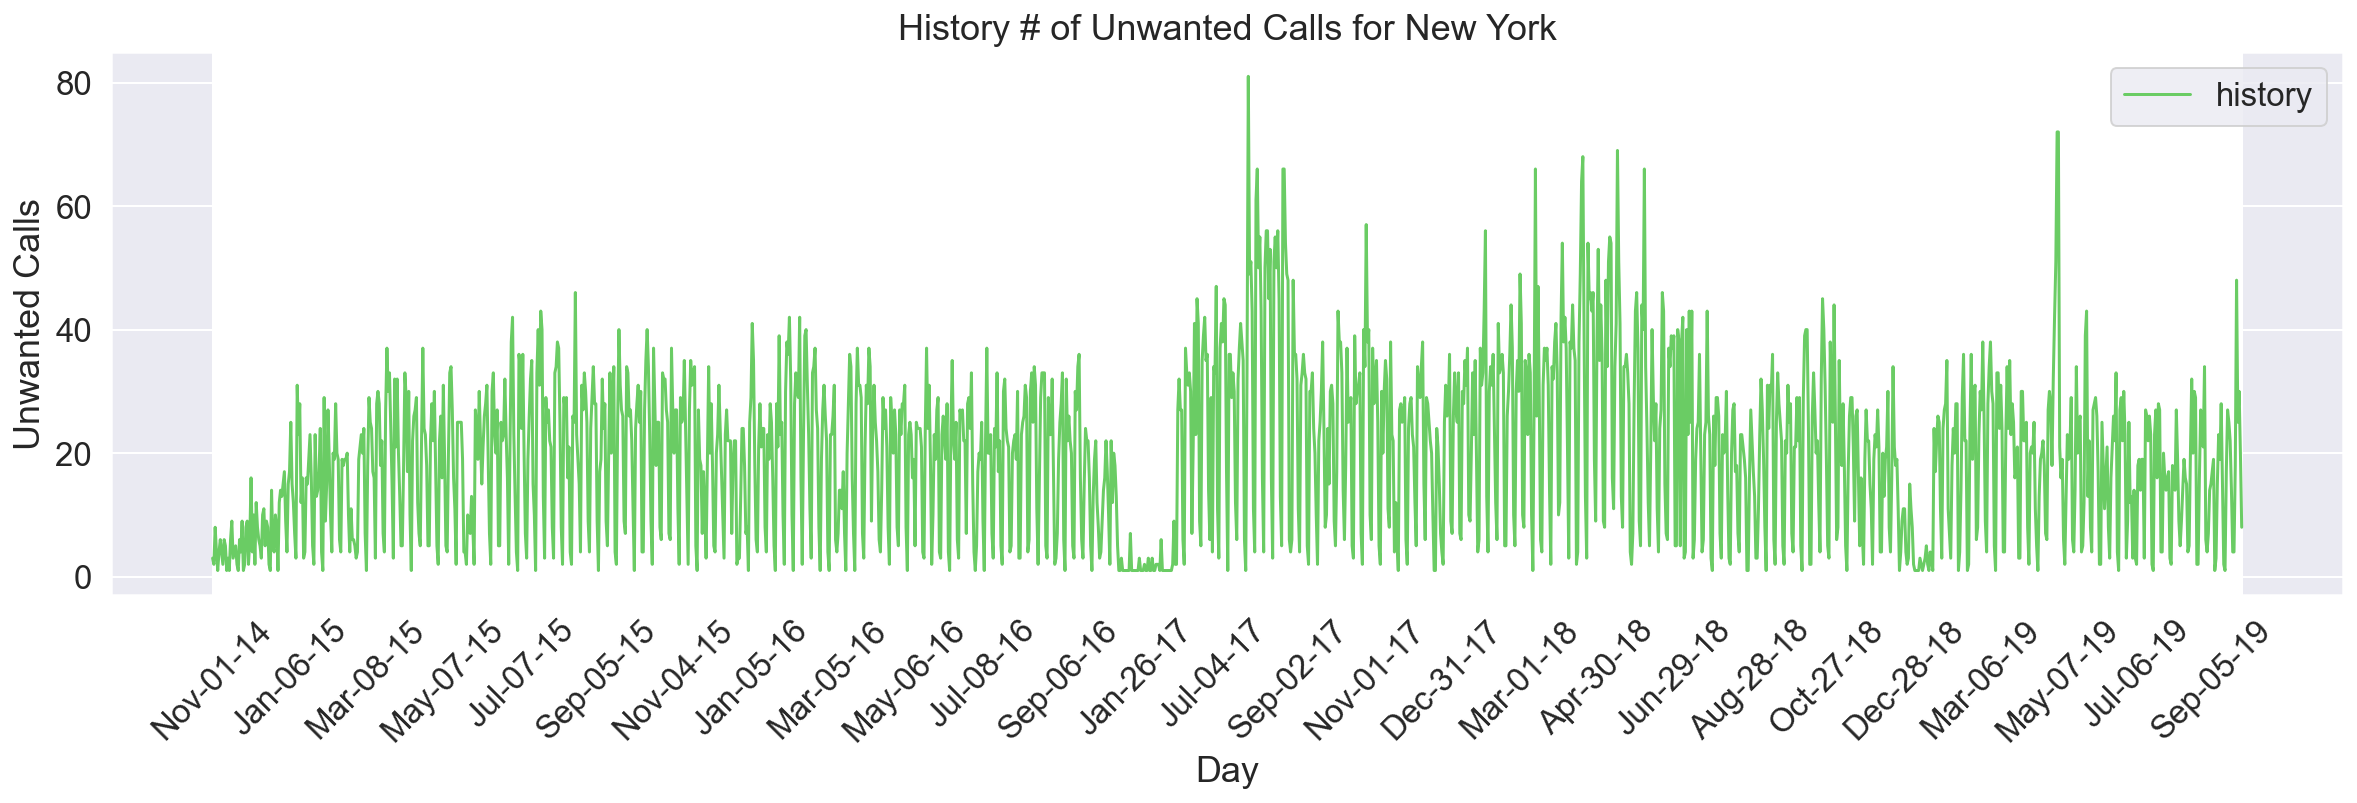

In [23]:
fig, ax = plt.subplots()
ax.set_title("History # of Unwanted Calls for "+ 'New York')
ax.plot(x_ticks_train, train, 'g', label="history")
ax.set_ylabel('Unwanted Calls')
ax.set_xlabel('Day')
every_nth = 60
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [24]:
x_ticks_test = [parse_date(x) for x in test.index]

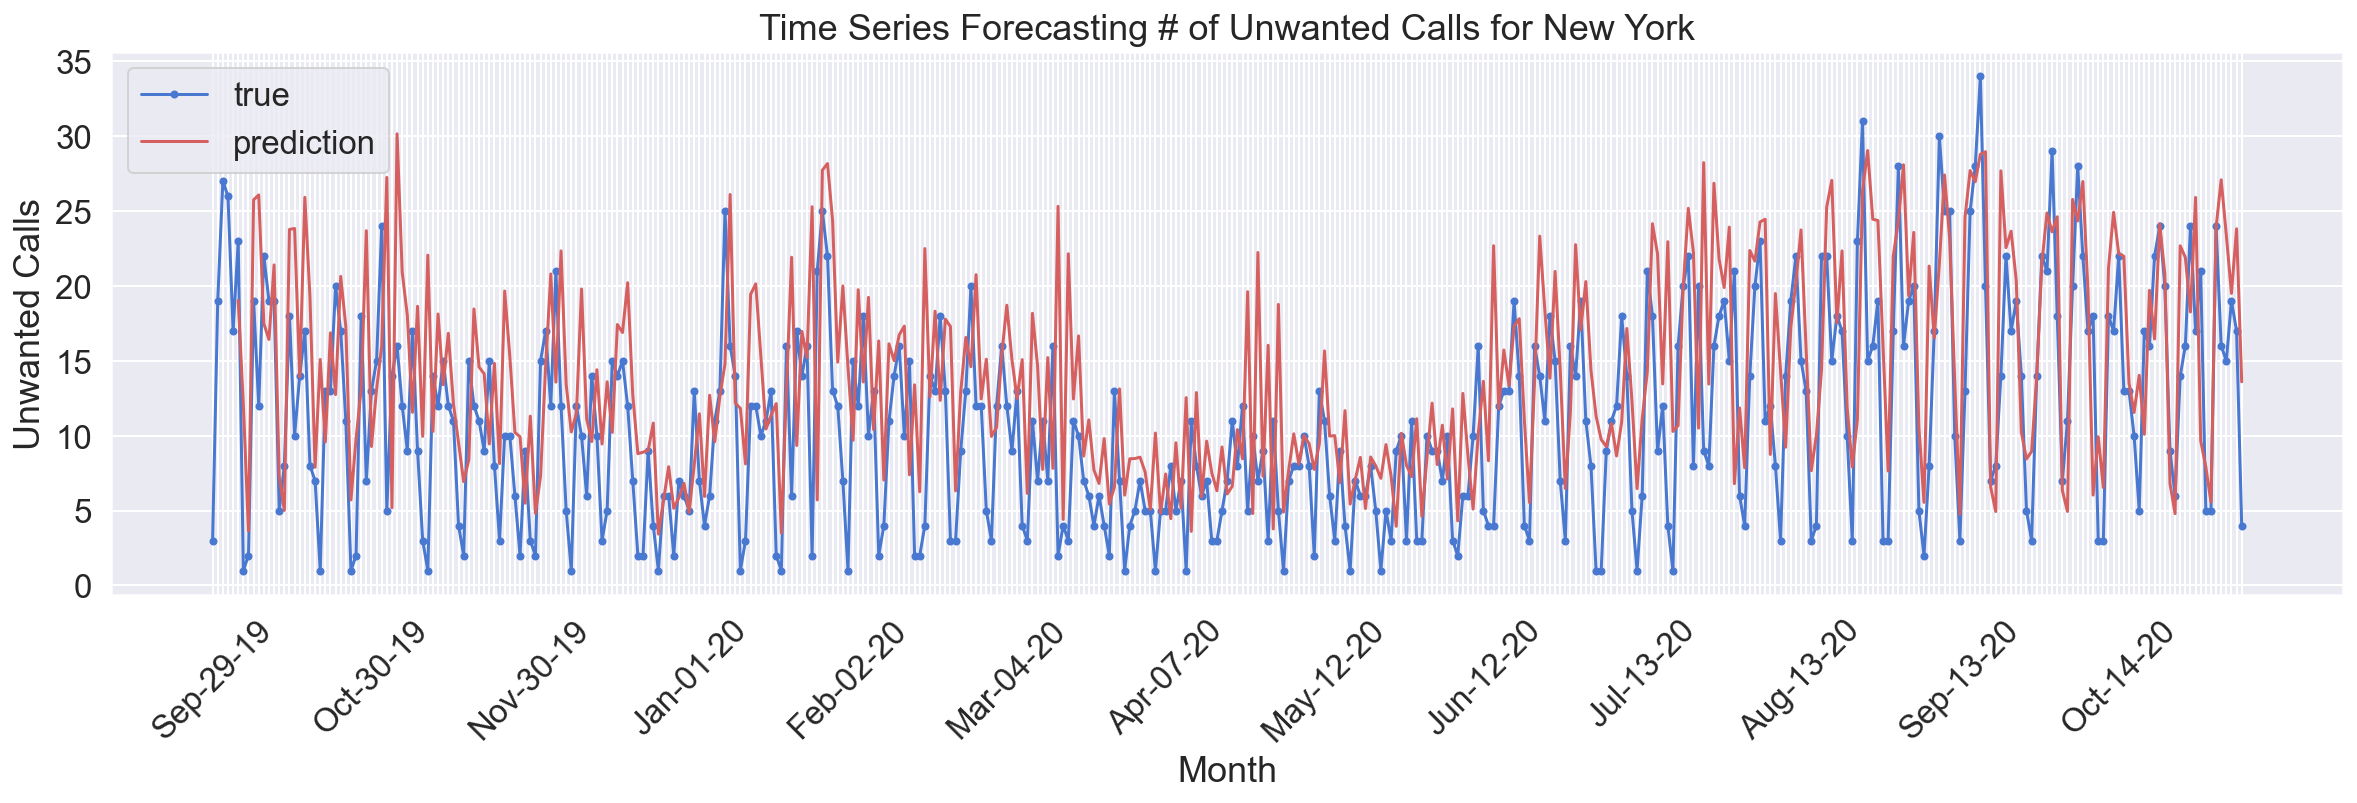

In [25]:
fig, ax = plt.subplots()
ax.set_title("Time Series Forecasting # of Unwanted Calls for "+ 'New York')
ax.plot(x_ticks_test, test, marker='.', label="true")
ax.plot(x_ticks_test[5:], y_pred_graph, 'r', label="prediction")
ax.set_ylabel('Unwanted Calls')
ax.set_xlabel('Month')

every_nth = 31
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.xticks(rotation=45)
plt.legend()
plt.show()